In [96]:
# !pip install numpy seaborn pandas scipy

In [97]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

ERR = 1e-10
STARTING_AGE = 20
MAX_EXTRA_YEARS = 120 - STARTING_AGE

# Part 1: The Live-Death Model

## Ultimate Survival Model

Define
$$
\mu_x = A + Bc^x
$$
where $A = 0.00022, B = 2.7\times10^{-6}, c = 1.124$.

Then, let $T$ be the lifespan of a person. We denote
$$
\begin{align*}
    {}_t p_x &= \Pr[T > x+t | T > x] \\
             &= e^{-\int_{s=0}^t \mu_{x+s}} \, ds
\end{align*}
$$
where $x$ is the starting age and $t$ is the number of years left.

In [98]:
from scipy.integrate import quad

def compute_mu(x):
    A = 0.00022
    B = 2.7e-6
    c = 1.124
    return A + B * c**x

def prob_of_living(x0, t):
    """
    x = current age
    t = number of years left
    => Pr[Living another t years | You are x y/o]
    """
    integral_val, _ = quad(lambda s: compute_mu(x0 + s), 0, t)
    return np.exp(-integral_val)

<Axes: xlabel="$t$'s", ylabel='Pr[Living t more years]'>

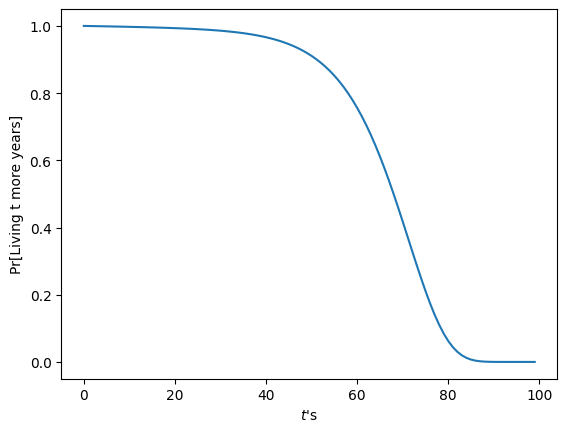

In [99]:
ts = np.arange(0, MAX_EXTRA_YEARS)
ys = np.array([prob_of_living(STARTING_AGE, t) for t in ts])

tp_data = pd.DataFrame({
    "$t$'s": ts,
    "Pr[Living t more years]": ys,
})

sns.lineplot(tp_data, x="$t$'s", y="Pr[Living t more years]")

## Modeling this as a Markov Chain

Let $S = \{A \text{(Alive)}, D \text{(Dead)}\}$. Obviously, $D$ is a recurrent state. We want to find the transition probability $A \to D$. Denote

$$
\begin{align*}
{}_k q_x &= \Pr[x+k \leq T \leq x+k+1 | T > x] \\
         &= {}_k p_x - {}_{k+1} p_x
\end{align*}
$$

Lastly, define the sequence of transition matrices $\{P_x(t)\}_{t=0}^\infty$
$$
P_x(t) = \begin{bmatrix}
    1 - {}_t q_x & {}_t q_x \\
    0 & 1
\end{bmatrix}
$$

<Axes: xlabel="$t$'s">

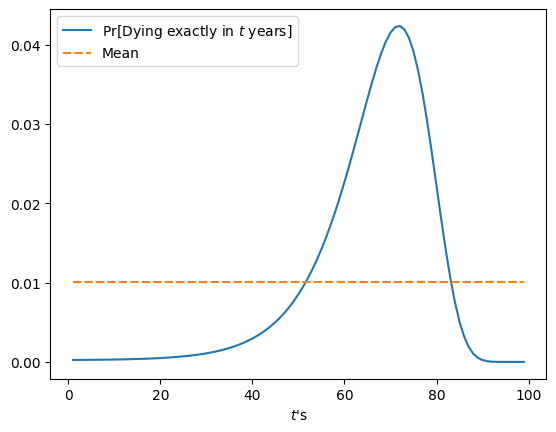

In [100]:
qs = np.array([ys[i-1] - ys[i] for i in range(1, MAX_EXTRA_YEARS)])
qs_mean = np.mean(qs)

tq_data = pd.DataFrame({
    "$t$'s": ts[1:],
    "Pr[Dying exactly in $t$ years]": qs,
    "Mean": qs_mean,
}).set_index("$t$'s")

sns.lineplot(tq_data)

Since this computation is rather expensive, we will try to look at alternative ways to compute ${}_t q_x$. Namely, we will try to fit it to some function or a known probability distribution. We have two choices here:
- A function that has a sharp increase and sharp decrease. This is very simple but it will not capture the shape of the curve very well.
- Skew Normal Distribution. This should give us higher precision compared to the simple function but will also be more expensive to compute.

In the end, the simple function used to fit ${}_t q_x$'s is
$$ f(x) = a \cdot \left(e^{-\frac{(x-b)^2}{c}}\right) $$
Yes, ChatGPT gave me this idea but not this exact function.

Obviously, we also tried with the Skew Normal Distribution.

In [101]:
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

def fitting_func(x, a, b, c):
    return a * np.exp(- (x-b)**2 / c)

def sn_fitting_func(x, xi, omg, alpha):
    return skewnorm.pdf(x, xi, omg, alpha)

opt_params, _ = curve_fit(fitting_func, ts[1:], qs)
sn_opt_params, _ = curve_fit(sn_fitting_func, ts[1:], qs, maxfev=10_000)
a0, b0, c0 = opt_params
xi0, omega0, alpha0 = sn_opt_params

fitted_qf = lambda x: fitting_func(x, a0, b0, c0)
sn_fitted_qf = lambda x: sn_fitting_func(x, xi0, omega0, alpha0)

(a0, b0, c0), (xi0, omega0, alpha0)

((0.041507927178874464, 69.53110084513646, 167.6366928196927),
 (-3.339332676700968, 79.36912671695876, 15.835646498702483))

<Axes: xlabel="$t$'s">

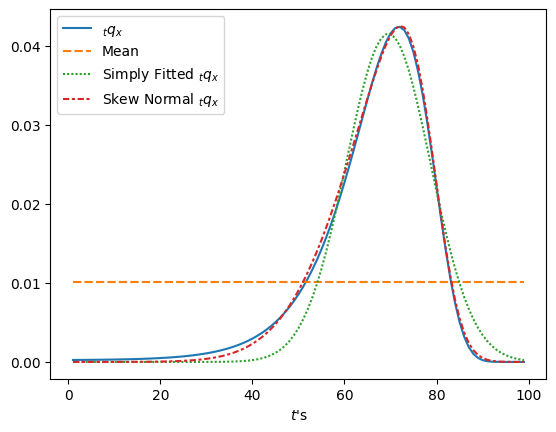

In [102]:
fitting_data = pd.DataFrame({
    "$t$'s": ts[1:],
    "${}_t q_x$": qs,
    "Mean": qs_mean,
    "Simply Fitted ${}_t q_x$": [fitted_qf(t) for t in ts[1:]],
    "Skew Normal ${}_t q_x$": [sn_fitted_qf(t) for t in ts[1:]],
}).set_index("$t$'s")

sns.lineplot(fitting_data)

## Expected Time to Live

An easy way out is to just compute
$$
\text{E}[T] = \sum_{t=0}^\infty t \cdot {}_t q_x
$$

Note: The computation here cuts off at around $t$ no more than 100-120 as at that point, the ${}_t q_x$ is so low that it will not contribute much more to the expected value. In fact, it is to the point that the precision is already lost due to floating-point arithmetics.

In [103]:
ts[1:] @ qs

66.41315159574077

Although the previous method is rather simple, it gets significantly more difficult once we introduce more states. The real question now is: How do we compute the expected time to live using Markov Chain-based methods? More specifically, what is the expected hitting time for $A \to D$ or $H_{A, D}$?

In [104]:
from scipy.optimize import fsolve

def compute_q(x0, t):
    t1 = prob_of_living(x0, t)
    t2 = prob_of_living(x0, t - 1)
    return t2 - t1

def compute_expected_at(t):
    q = compute_q(STARTING_AGE, t)
    
    def f_to_solve(mu):
        return 1 + (1 - q)*mu - mu
        
    soe_soln = fsolve(f_to_solve, [0])
    return soe_soln

In [105]:
# np.mean([compute_expected_at(t) for t in ts[1:]])
compute_expected_at(20)

array([2039.53822292])

# Part 2: The General Model